In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from preprocessing import preprocess
import h5py
import urllib.request
import re
from maayanlab_bioinformatics.harmonization import ncbi_genes
from get_symbol import get_symbol
from prediction_pipeline import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Gather gene expression data

In [2]:
f = pd.read_csv('GSE156063_swab_gene_counts.csv.gz')
f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
f = f.iloc[:, 1:] # Remove first index column 

In [3]:
# Normalize data 
norm = preprocess(f)

In [4]:
# Convert Ensembl number index to gene symbol
norm = get_symbol(norm)
norm

,RR057e_00202,RR057e_00080,RR057e_00287,RR057e_00753,RR057e_00751,RR057e_00520,RR057e_00505,RR057i_00083,RR057e_00764,RR057e_00451,...,RR057i_00136,RR057i_00137,RR057i_00156,RR057i_00158,RR057e_00719,RR057e_00721,RR057e_00731,RR057e_00728,RR057i_00067,RR057i_00116
TSPAN6,9.750394,8.431520,8.536410,9.230869,8.419235,5.561493,8.145934,9.775714,6.667802,7.745806,...,8.180515,5.026008,9.526165,9.177776,7.941530,4.877658,7.910921,9.262038,10.033367,7.944507
DPM1,6.127114,6.002366,5.249229,5.956564,6.316461,5.903046,5.496793,6.622060,5.609731,5.970437,...,6.457110,5.953559,6.916508,6.714337,6.672384,7.162435,6.332690,5.013840,6.716536,5.725258
SCYL3,7.153231,6.591814,6.363691,6.867613,7.007707,7.547516,7.490316,7.278342,6.637774,6.962121,...,6.819049,6.785380,7.175186,6.659617,6.882470,8.217438,6.770866,7.830724,8.741190,7.488884
C1orf112,4.997992,5.799738,5.683124,6.048044,5.018780,6.428549,5.156712,5.526507,6.292580,5.570527,...,4.446830,6.219428,5.485222,5.672800,5.617461,6.589548,3.500152,0.000000,6.209080,7.462111
FGR,2.879951,8.019425,8.486833,5.658744,4.616182,9.779217,9.013250,2.671251,10.250164,9.878493,...,7.235374,5.791892,5.649619,6.727083,6.785820,5.786167,4.190450,5.014101,5.410709,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287856,3.994869,5.268032,4.989002,3.355198,6.069830,8.355011,6.030361,4.080079,5.548841,6.573128,...,3.151128,5.504255,3.904021,4.138380,3.920471,4.872641,5.486766,5.008913,4.683105,4.091037
ENSG00000288258,0.381253,3.128959,0.741362,2.778832,4.494295,3.556651,2.403892,2.499549,3.556651,1.414968,...,3.304010,1.703540,1.119629,1.761382,2.820633,4.873239,3.494636,5.611814,3.624522,3.854520
ENSG00000288380,3.758763,0.257046,0.517748,0.877175,1.011474,4.267958,1.980540,1.130407,4.523328,1.416092,...,1.469524,0.989427,1.119629,0.900702,5.093880,6.588714,3.495341,5.365951,5.207784,2.973531
TMX2-CTNND1,5.747578,4.250350,5.048791,5.911258,4.322945,7.930172,4.013606,5.675303,5.923891,3.251837,...,4.621659,3.555366,3.804682,4.604726,7.120856,4.873239,3.495786,5.009396,2.869194,5.103178


# Gather ground truth data

In [8]:
gr_truth = pd.read_csv("GSE156063_series_matrix.txt", sep='\t')

In [9]:
gr_truth = gr_truth.iloc[10, 1:]
idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
gr_truth.index = idx

In [10]:
gr_truth = pd.DataFrame(gr_truth).loc[norm.columns]
test = [ 1 if res[-3:] == 'POS' else 0 for res in gr_truth.iloc[:, 0] ]
gr_truth.iloc[:, 0] = test
gr_truth.columns = ["Truth"]

# Nested cross-validation

In [15]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [16]:
X, y = norm.T, gr_truth.values.ravel()

1.0
0.9785714285714285
0.9642857142857142
0.9915966386554622
0.9230769230769231
0.9846153846153847
0.8968253968253969
0.9603174603174603
0.9196428571428571
0.8888888888888888
AUC: 0.951 (0.038)


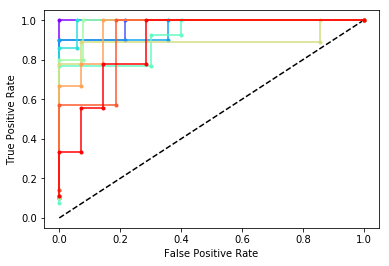

In [17]:
# generate no skill prediction
ns_probs = [0 for n in y]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')

# configure the cross-validation procedure 
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

# enumerate splits 
outer_results = []
summary = []
color=iter(cm.rainbow(np.linspace(0,1,10)))
for train_idx, test_idx in cv_outer.split(X):
    # split data 
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    # configure the cross-validation procedure 
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model 
    lassocv = LassoCV(alphas=None, cv=cv_inner, max_iter=100000)
    result = lassocv.fit(X_train, y_train)
    # evaluate model on the holdout dataset 
    yhat = result.predict(X_test)
    # evaluate model
    fpr, tpr, _ = roc_curve(y_test, yhat)
    auc_ = metrics.auc(fpr, tpr)
    outer_results.append(auc_)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', color=next(color))
    # report progress
    print(auc_)
    # add parameters to summary 
    summary.append(result.coef_)
# summarize estimated model performance
print('AUC: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [19]:
# get summary table 
sum_df = pd.DataFrame(summary, columns=X.columns)
sum_df

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,H3C2,ENSG00000286905,H3C3,ENSG00000287542,ENSG00000287725,ENSG00000287856,ENSG00000288258,ENSG00000288380,TMX2-CTNND1,DUS4L-BCAP29
0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
1,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
2,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0
3,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
4,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
5,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
6,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
7,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
8,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
9,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0


## Get gene lambda data

In [20]:
new_df = sum_df.loc[:, (sum_df != 0).any(axis=0)]

In [21]:
new_df

,MAD1L1,ABCB4,CRLF1,CEACAM7,TKTL1,PGLYRP1,CPS1,FHL1,STAP1,METTL1,...,SPECC1L-ADORA2A,TVP23C-CDRT4,MRC1,ENSG00000269711,GRIN2B,RIMBP3B,ENSG00000274744,F8A1,ENSG00000282034,ENSG00000285641
0,0.004081,0.000000,-0.023730,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.004400,...,-0.019755,0.00000,-0.009371,0.000000,-0.003400,0.000661,-0.00085,-0.000931,0.000000,0.00000
1,0.000000,0.000000,-0.011840,0.000000,-0.000567,-0.000000,-0.000000,0.000000,0.000000,-0.000314,...,-0.004105,0.00000,-0.000000,0.000000,-0.000000,0.000459,-0.00000,-0.000000,0.000000,0.00000
2,0.002334,0.000000,-0.022298,0.000000,-0.000000,-0.000000,-0.006609,0.007417,0.000142,-0.000000,...,-0.019474,0.00000,-0.000104,0.003859,-0.000000,0.019292,-0.00000,-0.000000,0.000000,0.00179
3,0.000000,0.000429,-0.011031,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.008992,0.00000,-0.000000,0.000000,-0.000000,0.000501,-0.00000,-0.000000,0.000000,0.00000
4,0.008503,0.000000,-0.009271,0.000579,-0.000000,-0.003356,-0.000000,0.000000,0.000000,-0.012338,...,-0.014817,0.00000,-0.001660,0.000998,-0.000928,0.004869,-0.00000,-0.000000,0.000000,0.00000
5,0.000000,0.000000,-0.009251,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.006110,0.00135,-0.001623,0.000000,-0.000000,0.006983,-0.00000,-0.000000,0.000000,0.00000
6,0.000000,0.000000,-0.014588,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.000000,0.00000,-0.000000,0.000000,-0.000000,0.000000,-0.00000,-0.000000,0.000000,0.00000
7,0.000000,0.000000,-0.018784,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.019284,0.00000,-0.000000,0.000000,-0.000000,0.003294,-0.00000,-0.000000,0.000000,0.00000
8,0.000000,0.000000,-0.008767,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,...,-0.002861,0.00000,-0.000000,0.000000,-0.000000,0.000000,-0.00000,-0.000000,0.000000,0.00000
9,0.016343,0.000000,-0.022181,0.000000,-0.000000,-0.000000,-0.000000,0.001098,0.000000,-0.000000,...,-0.020343,0.00000,-0.000000,0.006790,-0.000069,0.011106,-0.00000,-0.000000,0.004053,0.00000


In [22]:
lambda_counts = pd.DataFrame(new_df.astype(bool).sum(axis=0), columns=["Count"]).sort_values(by='Count', ascending=True)

In [23]:
lambda_counts

,Count
ADAMDEC1,1
CREB5,1
RNF175,1
FLG,1
CRNN,1
...,...
KRT13,10
IFI44L,10
RGPD2,10
ENSG00000257341,10


## Bar Plot

In [24]:
lambdas = lambda_counts.iloc[-30:]
lambdas.loc[:, 'Count'] /= 10
lambdas['labels'] = lambdas.index

/hpc/home/cy125/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


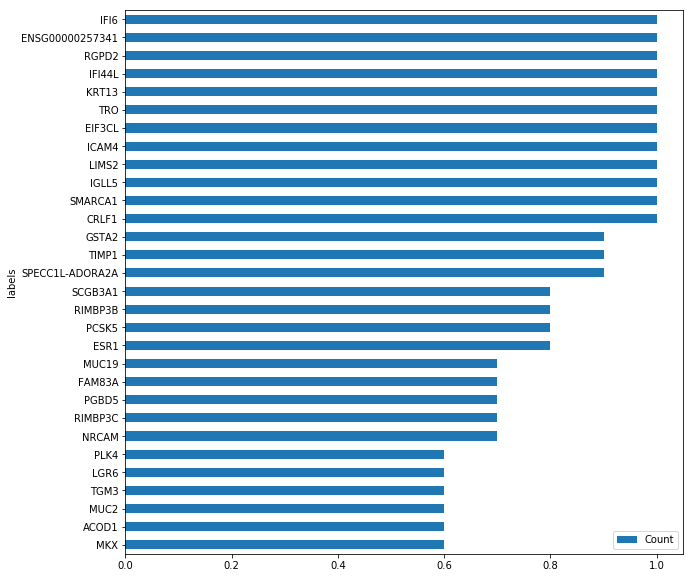

In [25]:
ax = lambdas.plot.barh(x='labels', y='Count', figsize=(10,10))

In [26]:
usage_dict = {"100% Usage": [0], "50% Usage": [0], "25% Usage": [0], "Total": [len(lambda_counts)]}
for val in lambda_counts.values:
    if val[0] == 10: usage_dict["100% Usage"][0] += 1
    elif val[0] > 5: usage_dict["50% Usage"][0] += 1
    elif val[0] > 2.5: usage_dict["25% Usage"][0] += 1

In [27]:
usage_df = pd.DataFrame(usage_dict, index=[''])
usage_df

,100% Usage,50% Usage,25% Usage,Total
,12,19,49,208


## Box Plot

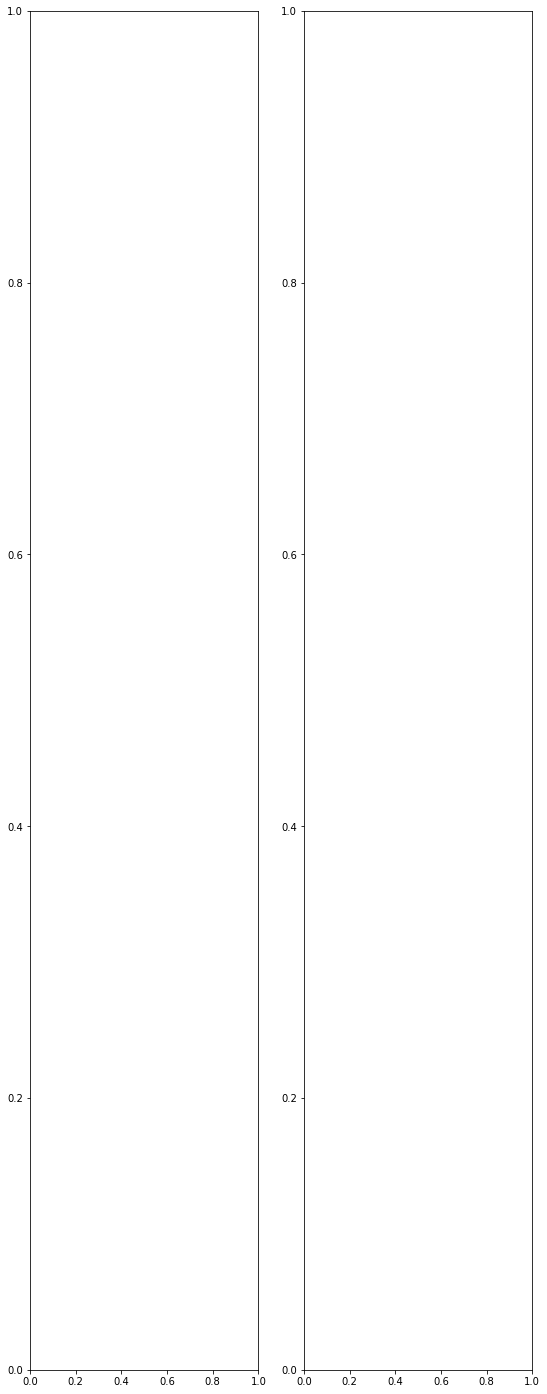

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 25))

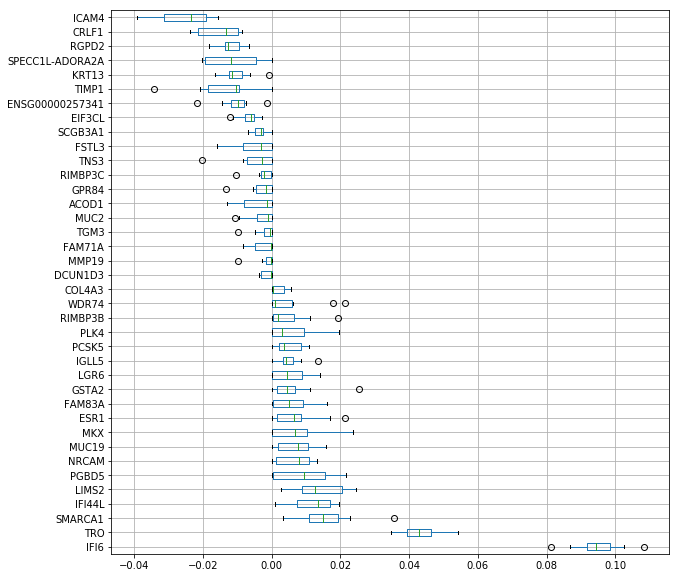

In [30]:
meds = sum_df.median()
meds.sort_values(ascending=False, inplace=True)
meds = meds[meds != 0]
df2 = sum_df[meds.index]
df2.boxplot(vert=False, rot=0, figsize=(10,10))